____________________________________

<div align="center">
  
# Data Science Technical Test 
# Glovo
### ___A Glovers churn prediction problem___
<br>
<br><br>
Nathan REDIN
<div align="center"> 
_____________________________________


<br><br><br>
### ___SUMMARY___:<br>
_The aim of this project is to tackle an important issue among the glovers community: __the churn__. <br>
We would like to be able to predict which drivers are going to churn on the next three weeks based on their lifetime data and informations about their behaviour for the last 7 weeks._ <br><br><br><br><br><br><br>

# Table of contents <br>
1. [__TASK 1 : Data Analysis and Data Processing__](#TITLE1)
    1. [Exploratory Data Analysis¶](#subparagraph1.1)
    2. [Data Munging¶](#subparagraph1.2) <br>
<br>
2. [__TASK 2 : Creation of a predictive algorithm__](#TITLE2)
    1. [First tests of some classification algorithms](#subparagraph2.1) 
    2. [Hyper-parameters tuning](#subparagraph2.2) <br>
<br>
3. [__Task 3 : Evaluation of the Model__](#TITLE3)
    1. [Model evaluation](#subparagraph3.1)
    2. [Model interpretation and features importances](#subparagraph3.2) <br>

<br><br><br><br>
<br><br>

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn import preprocessing, model_selection
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve, plot_confusion_matrix, f1_score

from xgboost import XGBClassifier

from scipy import stats

from progressbar import ProgressBar

from warnings import simplefilter

/Users/nathanredin/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/nathanredin/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/nathanredin/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# Ignore all future warnings (later from sklearn, ignore that line)
simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Upload of the datasets into pandas dataframes
df_lifetime = pd.read_csv(r"Courier_lifetime_data.csv", sep=",")
df_week = pd.read_csv(r"Courier_weekly_data.csv", sep=",")

<a name="TITLE1"></a>
## I. TASK 1 : Data Analysis and Data Processing 

### I. 1. Exploratory Data Analysis <a name="subparagraph1.1"></a>

#### a. General informations about the datasets

In [4]:
# Sparsity measure and Descriptive statistics: 

print('___________ Lifetime : __________',2*'\n')
print('Sparsity :','\n')
print(df_lifetime.info(),4*'\n','Descriptive statistics :',2*'\n',df_lifetime.describe())

print(5*'\n','___________ Weekly : __________',2*'\n')
print('Sparsity :','\n')
print(df_week.info(),4*'\n','Descriptive statistics :',2*'\n',df_week.describe())

___________ Lifetime : __________ 


Sparsity : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7524 entries, 0 to 7523
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   courier    7524 non-null   int64  
 1   feature_1  7524 non-null   object 
 2   feature_2  6588 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 176.5+ KB
None 



 Descriptive statistics : 

              courier    feature_2
count    7524.000000  6588.000000
mean   518864.440324    26.373862
std    286880.574472    22.703621
min       208.000000   -61.000000
25%    275875.750000    20.000000
50%    529366.500000    25.000000
75%    803120.500000    32.000000
max    964240.000000   954.000000





 ___________ Weekly : __________ 


Sparsity : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4117 entries, 0 to 4116
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -

#### b. Weekly dataframe analysis
<br>


Before keep going on the Data Processing of the weekly data frame, let's have a quick look at the correlation between the different features and the target and the correlation matrix (giving the pearson correlation between the different features) and see if all of the features bring a significant amount of information :

#### - Correlation between features and target :

In [5]:
# creation of a dataframe which contains the information of whether a courier worked or not on every single week:

# creation of the columns names:
col_name = ['courier']
for j in range(12):
    col_name.append('w_'+str(j))
# creation of the dataframe df_worked_week:    
df_worked_week = pd.DataFrame([],columns = col_name) 
df_worked_week.courier = df_week.courier.unique()


# fill of the 'worked on week i' features:
for i, courier in enumerate(df_worked_week.courier):
    for w in range(12):
        if df_week[(df_week.courier == courier) & (df_week.week == w)].empty : #if the glover courier didn't work on week w
            df_worked_week.loc[i:i+1,'w_' + str(w)] = 0
        else:    #if the glover courier worked on week w
            df_worked_week.loc[i:i+1,'w_' + str(w)] = 1

            
# add of the target to the data frame:
df_worked_week ['target'] = np.where((df_worked_week['w_9'] == 0) 
                             & (df_worked_week['w_10'] == 0) 
                             & (df_worked_week['w_11'] == 0), 1, 0)


In [6]:
df_worked_week.head()

,courier,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,target
0,3767,0,0,1,0,1,1,1,0,0,0,0,0,1
1,6282,0,0,1,1,1,1,1,1,0,1,1,1,0
2,10622,1,1,0,0,0,0,0,0,0,0,0,0,1
3,13096,0,0,0,0,0,1,1,0,1,1,1,1,0
4,14261,1,1,1,1,1,1,1,1,0,0,0,0,1


In [7]:
# Calculate of the correlations between the features and the target and sort of thoses correlations

df_week.merge(df_worked_week[['courier','target']], left_on='courier', right_on='courier', how='left').iloc[:,2:].corr()['target'].sort_values()

feature_3    -0.349718
feature_11   -0.295291
feature_2    -0.294234
feature_16   -0.198647
feature_14   -0.174546
feature_9    -0.114950
feature_1    -0.101587
feature_17   -0.084933
feature_15   -0.065347
feature_5    -0.034597
feature_6    -0.031046
feature_7    -0.013454
feature_8     0.030741
feature_4     0.034596
feature_12    0.081295
feature_10    0.096513
feature_13    0.134942
target        1.000000
Name: target, dtype: float64

We can notice that the __features 3, 11 and 2 are the most correlated to the churn__. The smaller those features are, the higher the probabilty of churning is.

#### - Pearson (bivariate) correlation analysis: 

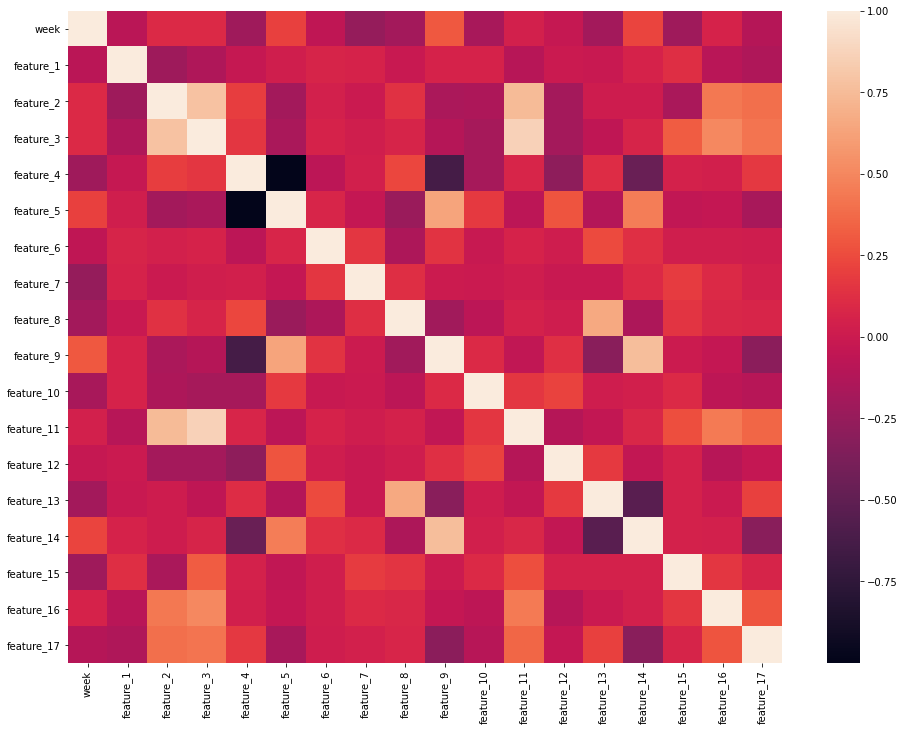

In [8]:
df_week_corr = df_week.iloc[:,1:].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(df_week_corr, 
            xticklabels = df_week_corr.columns.values,
            yticklabels = df_week_corr.columns.values,
            annot = False);

In [9]:
# number of couple of features with a correlation higher than 0.7

(sum(sum(np.array(abs(df_week_corr)>0.7)))-18)/2

5.0

We can notice that some features are extremely correlated. There is 5 couple of features with an absolute correlation higher than 0.7. Especially feature_4 and feature_5:

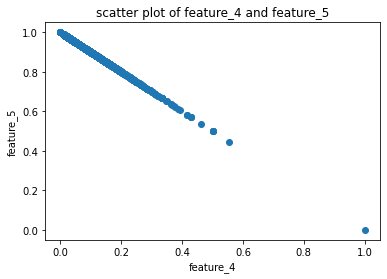

In [10]:
plt.scatter(df_week.feature_4,df_week.feature_5)
plt.ylabel('feature_5')
plt.xlabel('feature_4')
plt.title('scatter plot of feature_4 and feature_5')
plt.show()

Thus, considering the Occam's razor, it might be better do get rid of some of the unnecessary features. <br>
Instead of just delete certain features, a better solution could be to use a __Principal Component Analysis (PCA)__. <br> We will thus process a PCA in the next step : ___DATA MUNGING___

#### c. Lifetime <br>


#### - Correlation between features and target :

In [11]:
# data frame used to observe the correlations between the lifetime features and the target
df_correlation_lifetime_target = df_lifetime.dropna().merge(df_worked_week[['courier','target']], left_on='courier', right_on='courier', how='inner')

def cramers_v(x, y):
    '''Because feature_1 is a categorical variable, we'll check the Cramer's V 
    '''
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

cramers = cramers_v(df_correlation_lifetime_target['feature_1'],df_correlation_lifetime_target['target'])
print("The Cramer's V between lifetime feature_1 and the target (churn) is : " + str(cramers))

The Cramer's V between lifetime feature_1 and the target (churn) is : 0.1647640866492717


In [12]:
corr_feature_2_target = df_lifetime.dropna().merge(df_worked_week[['courier','target']], left_on='courier', right_on='courier', how='inner').iloc[:,1:].corr()['target']['feature_2']
print('The correlation between lifetime feature_2 and the target (churn) is : '+ str(corr_feature_2_target))

The correlation between lifetime feature_2 and the target (churn) is : -0.18074695799268536


### I. 2. Data Munging <a name="subparagraph1.2"></a>

#### a. Lifetime

#### Treat missing values 


From the Data Analysis part, we know there is 12.4% sparsity on feature_2. To deal with this sparsity there are several possible methods: <br>
- Delete the couriers with NaN for the feature_2. (We don't want to do it as we would loose informations)
- Replace the missing value by the mean (or the median) of the feature
- Replace the missing value by a value wich takes into account the other features (here feature_1)

In order to know which strategy is the most adapted to our data we should take a look at the distribution of the feature_2 for the 4 categories of feature_1 (a, b, c, d).

mean for categorie  a  with outliers:  30.709662921348315
mean for categorie  a  without outliers:  29.93159315931593 

mean for categorie  c  with outliers:  20.333333333333332
mean for categorie  c  without outliers:  20.333333333333332 

mean for categorie  d  with outliers:  32.305882352941175
mean for categorie  d  without outliers:  32.305882352941175 

mean for categorie  b  with outliers:  23.306550665301945
mean for categorie  b  without outliers:  23.07678525723061 



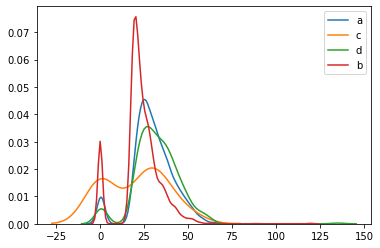

In [13]:
# Distribution :

# Creation of the dataframes corresponding to the categories:
df_lifetime_cat = dict()
mean_cat = dict()
for i, cat in enumerate(df_lifetime.feature_1.unique()):
    df_lifetime_cat[cat] = np.array(df_lifetime[(df_lifetime.feature_1 == cat) & (df_lifetime.feature_2.notna())]['feature_2'])
    print('mean for categorie ', cat, ' with outliers: ', np.mean(df_lifetime_cat[cat]))
    
    #remove of the outliers before displaying the distribution
    #which are more or less the values higher than a 150 or smaller than -10 
    df_lifetime_cat[cat] = df_lifetime_cat[cat][(np.array(df_lifetime_cat[cat]) < 150) & (np.array(df_lifetime_cat[cat]) > -10)] 
    print('mean for categorie ', cat, ' without outliers: ', np.mean(df_lifetime_cat[cat]),'\n')
    mean_cat[cat] = np.mean(df_lifetime_cat[cat])
    

    sns.kdeplot(df_lifetime_cat[cat],label = cat) #display of the distribution without the outliers
 
    

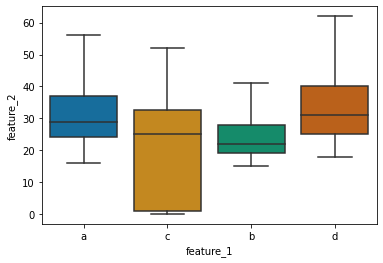

In [14]:
# BoxPlot without the outliers

df_lifetime_plot = df_lifetime[df_lifetime.feature_2.notna()]
sns.boxplot(y = 'feature_2', x = 'feature_1', 
                 data = df_lifetime_plot, 
                 palette="colorblind", showfliers = False) 

Before displaying the boxplots without the option 'showfliers = False'(with the outliers), I have noticed that there are outliers 
for categories a and b. Those outliers modify a bit the values of the mean. However, we can notice that the median is quit the same. <br>
I have eventually decided to __replace the NaN by the average value of the feature_2 without outliers for the corresponding 
category for feature_1__.
(Another point we could notice is that for every categories of lifetime feature_1, the __feature_2 distribution is bimodal__ but we do not have enough informations to know in which mode a courier is, a clustering analysis or the add of a new lifetime feature would have been interesting).

In [15]:
df_lifetime['feature_2'] = df_lifetime['feature_2'].fillna(df_lifetime.groupby("feature_1")["feature_2"].transform("mean"))

In [16]:
print('___________ Lifetime : __________',2*'\n')
print('Sparsity :','\n')
print(df_lifetime.info(),4*'\n','Descriptive statistics :',2*'\n',df_lifetime.describe())

___________ Lifetime : __________ 


Sparsity : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7524 entries, 0 to 7523
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   courier    7524 non-null   int64  
 1   feature_1  7524 non-null   object 
 2   feature_2  7524 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 176.5+ KB
None 



 Descriptive statistics : 

              courier    feature_2
count    7524.000000  7524.000000
mean   518864.440324    26.307108
std    286880.574472    21.288345
min       208.000000   -61.000000
25%    275875.750000    21.000000
50%    529366.500000    25.000000
75%    803120.500000    31.000000
max    964240.000000   954.000000


The NaN replacement went well, there is no more null values.

#### b. weekly

#### Data Normalization and PCA

Before considering a PCA, I'll proceed to the ___Data Normalization___ of df_week:

In [17]:
'''There is no missing values in the weekly dataframe so for the next steps
we can already normalize the features'''
# normalization of the features 

val = df_week.iloc[:,2:].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
val_scaled = min_max_scaler.fit_transform(val)
df_week.iloc[:,2:] = pd.DataFrame(val_scaled, columns = df_week.iloc[:,2:].columns)

In [18]:
df_week.describe()

,courier,week,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17
count,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000
mean,366530.934418,4.910857,0.624640,0.257335,0.290910,0.068610,0.931390,0.109403,0.089004,0.247798,0.767527,0.391970,0.235662,0.239153,0.209276,0.782381,0.369290,0.104627,0.060770
std,128603.611959,3.364852,0.080964,0.142899,0.168439,0.068999,0.068999,0.080789,0.096964,0.107972,0.136458,0.101708,0.144884,0.052563,0.103696,0.164578,0.105838,0.128581,0.060263
min,3767.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,280239.000000,2.000000,0.586047,0.148810,0.159574,0.018500,0.901200,0.068104,0.000000,0.140893,0.693700,0.325499,0.127907,0.209109,0.140143,0.739100,0.308494,0.000000,0.020619
50%,406936.000000,5.000000,0.632558,0.238095,0.265957,0.054100,0.945900,0.072539,0.065247,0.258587,0.785700,0.385215,0.220930,0.233378,0.194299,0.822200,0.386141,0.083333,0.046392
75%,467727.000000,8.000000,0.669767,0.345238,0.398936,0.098800,0.981500,0.113546,0.132293,0.317468,0.864200,0.446964,0.325581,0.261034,0.253157,0.883700,0.445314,0.166667,0.082474
max,519341.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### PCA

In [19]:
#PCA

pca = PCA(n_components=17)
principalComponents = pca.fit_transform(df_week.iloc[:,2:])
principalDf = pd.DataFrame(data = principalComponents)

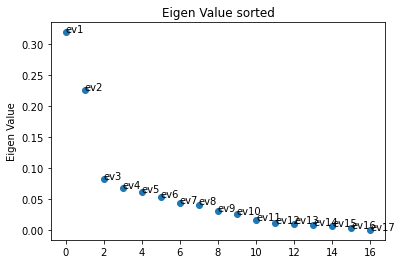

In [20]:
y = pca.explained_variance_ratio_
z = range(len(pca.explained_variance_ratio_))
n = []
for i in range(17):
        n.append('ev'+str(i+1))

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

plt.ylabel('Eigen Value')
plt.title('Eigen Value sorted')
plt.show()

[0.3188368140166495, 0.543891372597497, 0.6253135469682839, 0.6927439120901483, 0.7532553023071624, 0.8060577981834293, 0.8489136635760203, 0.8896697354253689, 0.919434321237872, 0.944969213953883, 0.960996689775908, 0.9722251991689055, 0.9825276070841, 0.9906450617326364, 0.9968904485331967, 0.9999999997929208, 0.9999999999999999]


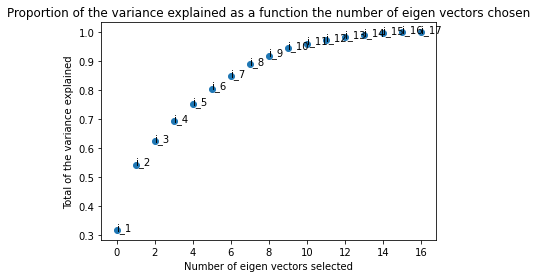

In [21]:
sum_var = [0]
for i in range(17):
    sum_var.append(sum_var[-1]+y[i])
sum_var = sum_var[1:]

z = range(len(pca.explained_variance_ratio_))
n = []
for i in range(17):
        n.append('i_'+str(i+1))

fig, ax = plt.subplots()
ax.scatter(z, sum_var)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], sum_var[i]))
print(sum_var)

plt.ylabel('Total of the variance explained')
plt.xlabel('Number of eigen vectors selected')
plt.title('Proportion of the variance explained as a function the number of eigen vectors chosen')
plt.show()

__Results of the PCA :__ <br>
We can notice that the variance explained increase quickly and then slows down from around the 11'th eigen vector. <br>
We could then keep only the eigen vectors that represents the most of the variance. The first 10 eigen vectors bring most of the explained variance (96%). <br>
Thus, I decide to keep only those 10 eigen vectors. 


In [22]:
# replace df_week with the new features obtained with the PCA

df1 = df_week.iloc[:,0:2]
df2 = pd.DataFrame(principalComponents[:,0:10], columns = ['PC_'+str(i+1) for i in range(10)])
df_week = pd.concat([df1, df2], axis=1)
df_week.head()

,courier,week,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
0,3767,2,-0.197518,-0.028071,0.121019,0.065226,0.091357,-0.022928,0.117339,0.359929,0.115147,0.095282
1,3767,4,-0.109800,-0.225275,0.047072,0.072611,-0.150379,0.184709,0.137377,0.244301,0.127276,0.116829
2,3767,5,-0.156778,-0.229683,0.177220,0.131196,-0.018481,-0.028148,-0.017428,0.277041,0.196779,0.009968
3,3767,6,0.128969,-0.048616,0.291311,0.067048,-0.090015,-0.057296,-0.020106,0.188589,0.005287,0.070475
4,6282,2,-0.280686,-0.115248,0.074749,0.124274,0.022638,-0.045784,-0.015993,-0.034526,0.035521,-0.049110


Even though there is no missing values in any features for the weekly data, some of the courier - week data combinations are not provided considering the courriers don't work every weeks. <br>
Because we'll need to use a regular input shape for the model later on, we'll have to deal with those missing values.<br>
One way to do so would be to add a boolean variable (worked on week i noted __w_i__ defined earlier during the data analysis) indicating if a glover worked or not for every week (so 12 more features in total) and then create data for the 10 features for the weeks the glovers didn't work. 
Since we add a variable "worked on week i" __w_i__ taking value 0 or 1, and as long as we use a non linear model, the values inputed into the features 1 to 10 for the missing weeks do not really matter. Thus, we could just input the average value of the feature (for example). 

#### Creation of df_processed :  the data_frame eventually used for the training part

In [23]:
# creation of the dataframe with the different features and the different weeks : w_0_feature_1 to w_11_feature_10

#creation of the columns names:
col_name = ['courier']
for j in range(12):
    col_name.append('w_'+str(j))
    for i in range(10):
        col_name.append('w_'+str(j)+'_feature_'+str(i+1)) 

# creation of the dataframe processed df_processed used later for the training part
df_processed = pd.DataFrame([],columns = col_name) 


In [24]:
# copy of the glovers id:

df_processed.courier = df_week.courier.unique()
len(df_week.courier.unique())

759

There is __759 glovers__ with weekly informations (actives at least one of the last 11 weeks)

In [25]:
# fill of the 'worked on week i' features:
df_processed[['w_' + str(i) for i in range(12)]] = df_worked_week.iloc[:,1:-1]

In [26]:
# fill the w_i_feature_j (with the value from df_week when it is avaible (when the glover worked) 
# or with the mean of the feature otherwise :

x=1
pbar = ProgressBar()
for i, courier in enumerate(pbar(df_processed.courier)):
    for w in range(12):
        if df_week[(df_week.courier == courier) & (df_week.week == w)].empty : #if the glover courier didn't work on week w,
            #we replace the value by the average value of the feature. 
            df_processed.iloc[i:i+1,w*11+2:w*11+12] = list(df_week.describe().loc['mean',:])[2:]
        else: #otherwise we just input the known value
            df_processed.iloc[i:i+1,w*11+2:w*11+12] = list(df_week[(df_week['courier'] == courier) & (df_week['week'] == w)].iloc[0,2:])


100% |########################################################################|


In [27]:
# add of the target to the data frame:

df_processed ['target'] = df_worked_week ['target']

In [28]:
df_processed.head()

,courier,w_0,w_0_feature_1,w_0_feature_2,w_0_feature_3,w_0_feature_4,w_0_feature_5,w_0_feature_6,w_0_feature_7,w_0_feature_8,...,w_11_feature_2,w_11_feature_3,w_11_feature_4,w_11_feature_5,w_11_feature_6,w_11_feature_7,w_11_feature_8,w_11_feature_9,w_11_feature_10,target
0,3767,0,-4.42255e-17,2.12161e-17,4.46857e-17,5.2983e-17,1.11373e-17,2.80952e-17,6.02202e-18,-1.03776e-17,...,2.12161e-17,4.46857e-17,5.2983e-17,1.11373e-17,2.80952e-17,6.02202e-18,-1.03776e-17,-2.37611e-17,3.49136e-17,1
1,6282,0,-4.42255e-17,2.12161e-17,4.46857e-17,5.2983e-17,1.11373e-17,2.80952e-17,6.02202e-18,-1.03776e-17,...,-0.253882,-0.0223389,0.120794,0.0515715,0.0637042,-0.0433273,-0.0535366,0.0311076,-0.0737482,0
2,10622,1,0.0802699,0.210758,0.308797,-0.00974279,-0.0321708,0.122141,0.212806,-0.0326548,...,2.12161e-17,4.46857e-17,5.2983e-17,1.11373e-17,2.80952e-17,6.02202e-18,-1.03776e-17,-2.37611e-17,3.49136e-17,1
3,13096,0,-4.42255e-17,2.12161e-17,4.46857e-17,5.2983e-17,1.11373e-17,2.80952e-17,6.02202e-18,-1.03776e-17,...,-0.171401,0.214957,0.236688,-0.159487,-0.0263062,0.0167298,0.0435214,-0.0384093,0.000145729,0
4,14261,1,0.0847451,-0.0901285,0.0542134,0.178307,-0.0344218,-0.013468,0.208567,0.189786,...,2.12161e-17,4.46857e-17,5.2983e-17,1.11373e-17,2.80952e-17,6.02202e-18,-1.03776e-17,-2.37611e-17,3.49136e-17,1


In [29]:
sum(df_processed.isna().sum())

0

In [30]:
len(df_processed)

759

The processing went well. There is no more empty values. <br> <br>

#### Add of the lifetime features to df_processed

In [31]:
# Left join on the lifetime Data Frame to get the lifetime feature_1 and feature_2
df_processed = df_processed.merge(df_lifetime, left_on='courier', right_on='courier', how='inner')
df_processed = df_processed.rename(columns = {'feature_1':'lt_feature_1','feature_2':'lt_feature_2'})

In [32]:
df_processed.head()

,courier,w_0,w_0_feature_1,w_0_feature_2,w_0_feature_3,w_0_feature_4,w_0_feature_5,w_0_feature_6,w_0_feature_7,w_0_feature_8,...,w_11_feature_4,w_11_feature_5,w_11_feature_6,w_11_feature_7,w_11_feature_8,w_11_feature_9,w_11_feature_10,target,lt_feature_1,lt_feature_2
0,3767,0,-4.42255e-17,2.12161e-17,4.46857e-17,5.2983e-17,1.11373e-17,2.80952e-17,6.02202e-18,-1.03776e-17,...,5.2983e-17,1.11373e-17,2.80952e-17,6.02202e-18,-1.03776e-17,-2.37611e-17,3.49136e-17,1,b,33.0
1,6282,0,-4.42255e-17,2.12161e-17,4.46857e-17,5.2983e-17,1.11373e-17,2.80952e-17,6.02202e-18,-1.03776e-17,...,0.120794,0.0515715,0.0637042,-0.0433273,-0.0535366,0.0311076,-0.0737482,0,a,35.0
2,10622,1,0.0802699,0.210758,0.308797,-0.00974279,-0.0321708,0.122141,0.212806,-0.0326548,...,5.2983e-17,1.11373e-17,2.80952e-17,6.02202e-18,-1.03776e-17,-2.37611e-17,3.49136e-17,1,b,35.0
3,13096,0,-4.42255e-17,2.12161e-17,4.46857e-17,5.2983e-17,1.11373e-17,2.80952e-17,6.02202e-18,-1.03776e-17,...,0.236688,-0.159487,-0.0263062,0.0167298,0.0435214,-0.0384093,0.000145729,0,a,35.0
4,14261,1,0.0847451,-0.0901285,0.0542134,0.178307,-0.0344218,-0.013468,0.208567,0.189786,...,5.2983e-17,1.11373e-17,2.80952e-17,6.02202e-18,-1.03776e-17,-2.37611e-17,3.49136e-17,1,a,44.0


In [33]:
# indexing of df_processed by courier
df_processed.set_index('courier', inplace = True)

#### Dummification of the categorical feature lt_feature_1

In [34]:
df_processed = pd.concat([df_processed, pd.get_dummies(df_processed['lt_feature_1'],prefix = 'lt_feature_1')], axis = 1)
df_processed.drop('lt_feature_1', axis=1, inplace = True)
df_processed.head()

,w_0,w_0_feature_1,w_0_feature_2,w_0_feature_3,w_0_feature_4,w_0_feature_5,w_0_feature_6,w_0_feature_7,w_0_feature_8,w_0_feature_9,...,w_11_feature_7,w_11_feature_8,w_11_feature_9,w_11_feature_10,target,lt_feature_2,lt_feature_1_a,lt_feature_1_b,lt_feature_1_c,lt_feature_1_d
courier,,,,,,,,,,,,,,,,,,,,,
3767,0,-4.42255e-17,2.12161e-17,4.46857e-17,5.2983e-17,1.11373e-17,2.80952e-17,6.02202e-18,-1.03776e-17,-2.37611e-17,...,6.02202e-18,-1.03776e-17,-2.37611e-17,3.49136e-17,1,33.0,0,1,0,0
6282,0,-4.42255e-17,2.12161e-17,4.46857e-17,5.2983e-17,1.11373e-17,2.80952e-17,6.02202e-18,-1.03776e-17,-2.37611e-17,...,-0.0433273,-0.0535366,0.0311076,-0.0737482,0,35.0,1,0,0,0
10622,1,0.0802699,0.210758,0.308797,-0.00974279,-0.0321708,0.122141,0.212806,-0.0326548,0.0444662,...,6.02202e-18,-1.03776e-17,-2.37611e-17,3.49136e-17,1,35.0,0,1,0,0
13096,0,-4.42255e-17,2.12161e-17,4.46857e-17,5.2983e-17,1.11373e-17,2.80952e-17,6.02202e-18,-1.03776e-17,-2.37611e-17,...,0.0167298,0.0435214,-0.0384093,0.000145729,0,35.0,1,0,0,0
14261,1,0.0847451,-0.0901285,0.0542134,0.178307,-0.0344218,-0.013468,0.208567,0.189786,0.0531061,...,6.02202e-18,-1.03776e-17,-2.37611e-17,3.49136e-17,1,44.0,1,0,0,0


#### Some final processings before training:

In [35]:
# remove of the weeks 8 to 11:
df_processed = pd.concat([df_processed.iloc[:,0:-50], df_processed.iloc[:,-6:]],axis = 1)

In [36]:
df_processed.head()

,w_0,w_0_feature_1,w_0_feature_2,w_0_feature_3,w_0_feature_4,w_0_feature_5,w_0_feature_6,w_0_feature_7,w_0_feature_8,w_0_feature_9,...,w_7_feature_7,w_7_feature_8,w_7_feature_9,w_7_feature_10,target,lt_feature_2,lt_feature_1_a,lt_feature_1_b,lt_feature_1_c,lt_feature_1_d
courier,,,,,,,,,,,,,,,,,,,,,
3767,0,-4.42255e-17,2.12161e-17,4.46857e-17,5.2983e-17,1.11373e-17,2.80952e-17,6.02202e-18,-1.03776e-17,-2.37611e-17,...,6.02202e-18,-1.03776e-17,-2.37611e-17,3.49136e-17,1,33.0,0,1,0,0
6282,0,-4.42255e-17,2.12161e-17,4.46857e-17,5.2983e-17,1.11373e-17,2.80952e-17,6.02202e-18,-1.03776e-17,-2.37611e-17,...,-0.00532257,0.19246,0.0776793,0.0864874,0,35.0,1,0,0,0
10622,1,0.0802699,0.210758,0.308797,-0.00974279,-0.0321708,0.122141,0.212806,-0.0326548,0.0444662,...,6.02202e-18,-1.03776e-17,-2.37611e-17,3.49136e-17,1,35.0,0,1,0,0
13096,0,-4.42255e-17,2.12161e-17,4.46857e-17,5.2983e-17,1.11373e-17,2.80952e-17,6.02202e-18,-1.03776e-17,-2.37611e-17,...,6.02202e-18,-1.03776e-17,-2.37611e-17,3.49136e-17,0,35.0,1,0,0,0
14261,1,0.0847451,-0.0901285,0.0542134,0.178307,-0.0344218,-0.013468,0.208567,0.189786,0.0531061,...,0.129808,0.148851,-0.0782919,0.0255109,1,44.0,1,0,0,0


In [37]:
# saving of the dataframe if we just want to import it without running all the dataprocessing
df_processed.to_csv(r'df_processed.csv', index = False)


In [38]:
# import of the data frame df_processed from the saved file df_processed.csv
df_processed = pd.read_csv(r'df_processed.csv')

<a name="TITLE2"></a>
## II. TASK 2 : Creation of a predictive algorithm 

First of all lets check the repartition of the target: 

In [39]:
sum(df_processed.target)/len(df_processed)

0.4901185770750988

The target is almost evenly spread so, apparently there is no need for now to weight the classes for the training.

In [40]:
X = df_processed.apply(pd.to_numeric).drop('target', axis=1)
y = df_processed['target'].apply(pd.to_numeric)

In [41]:
# Train Validation Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 66)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.33, random_state = 66)


### II. 1. First tests of some classification algorithms with hyper parameters default values <a name="subparagraph2.1"></a>

For this step the metric we will use for the training of the algorithm is the default metric for this kind of problem: __the minimization of the error__ (or __maximization of the accuracy__)

In [43]:
# function to display the performances of the model on the validation set:

def print_metrics(model,cv_score,X_validation,y_validation):
    prediction = model.predict(X_validation)
    print("=== Confusion Matrix ===")
    disp = plot_confusion_matrix(model, X_validation,y_validation,cmap=plt.cm.Blues)
    disp.ax_.set_title('Confusion Matrix')
    plt.show()
    print('\n')
    print("=== Classification Report ===")
    print(classification_report(y_validation, prediction))
    print('\n')
    print("=== All AUC Scores ===")
    print(cv_score)
    print('\n')
    print("=== Mean AUC Score ===")
    print("Mean AUC Score : ", cv_score.mean())
    print('\n')
    print("=== Total count ===")
    print("Total of active glovers : " + str(sum(y_validation==0)) + "  Predicted number of active glovers : " + str(sum(prediction==0)))
    print("Delta = " + str( round((100*(sum(prediction==0) - sum(y_validation==0))/sum(y_validation==0) ),3)) + '%')

### a. Logistic Regression

In [42]:
lr = LogisticRegression(random_state=0,max_iter = 1000)
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_validation)

=== Confusion Matrix ===


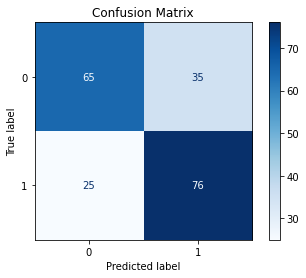



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       100
           1       0.68      0.75      0.72       101

    accuracy                           0.70       201
   macro avg       0.70      0.70      0.70       201
weighted avg       0.70      0.70      0.70       201



=== All AUC Scores ===
[0.8  0.76 0.69 0.78 0.78 0.94 0.61 0.69 0.69 0.86]


=== Mean AUC Score ===
Mean AUC Score :  0.7600000000000001


=== Total count ===
Total of active glovers : 100  Predicted number of active glovers : 90
Delta = -10.0%


In [44]:
lr_cv_score = cross_val_score(lr, X_validation, y_validation, cv=10, scoring='roc_auc')
print_metrics(lr,lr_cv_score,X_validation,y_validation)


### b. Random Forest

In [45]:
# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_validation)

=== Confusion Matrix ===


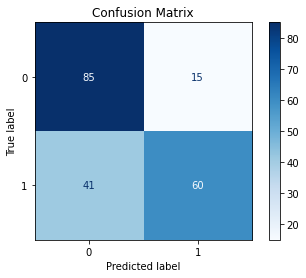



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.67      0.85      0.75       100
           1       0.80      0.59      0.68       101

    accuracy                           0.72       201
   macro avg       0.74      0.72      0.72       201
weighted avg       0.74      0.72      0.72       201



=== All AUC Scores ===
[0.83636364 0.58       0.68       0.66       0.87       0.82
 0.695      0.755      0.585      0.82      ]


=== Mean AUC Score ===
Mean AUC Score :  0.7301363636363637


=== Total count ===
Total of active glovers : 100  Predicted number of active glovers : 126
Delta = 26.0%


In [46]:
rfc_cv_score = cross_val_score(rfc, X_validation, y_validation, cv=10, scoring='roc_auc')
print_metrics(rfc,rfc_cv_score,X_validation,y_validation)

### c. XGBoost

=== Confusion Matrix ===


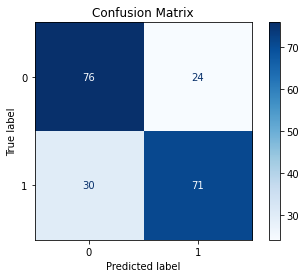



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       100
           1       0.75      0.70      0.72       101

    accuracy                           0.73       201
   macro avg       0.73      0.73      0.73       201
weighted avg       0.73      0.73      0.73       201



=== All AUC Scores ===
[0.78181818 0.59       0.6        0.61       0.84       0.9
 0.75       0.72       0.75       0.99      ]


=== Mean AUC Score ===
Mean AUC Score :  0.7531818181818182


=== Total count ===
Total of active glovers : 100  Predicted number of active glovers : 106
Delta = 6.0%


In [47]:
XGB = XGBClassifier()
XGB.fit(X_train, y_train)
XGB_predict = XGB.predict(X_validation)
XGB_cv_score = cross_val_score(XGB, X_validation, y_validation, cv=10, scoring='roc_auc')
print_metrics(XGB,XGB_cv_score,X_validation,y_validation)

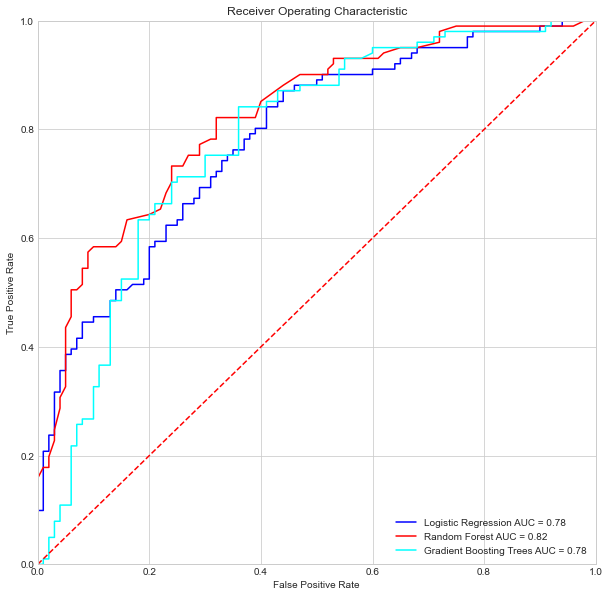

In [48]:
# Plot of the ROC curves

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10)) 

# calculate the fpr and tpr for all thresholds of the classification

models_names = [
    'Logistic Regression', 
    'Random Forest', 
    'Gradient Boosting Trees'
]

models = [
    lr,
    rfc,
    XGB]

colors = [
    'blue',
    'red',
    'cyan',
]


def plot_roc_curves(model,model_name, color):
    probs = model.predict_proba(X_validation)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_validation, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = model_name + ' AUC = %0.2f' % roc_auc, color=color)
    plt.legend(loc = 'lower right')
    
for i, model in list(enumerate(models)):
    plot_roc_curves(model, models_names[i], colors[i])

plt.title('Receiver Operating Characteristic')
#plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### d. Model selection and Hyper-parameters tuning

#### Business and metrics analysis, model selection:
The main question here is to know whether we would like to prioritize the ___glovers' income maximization___ and ___cost efficiency___ or the ___marketplace reliability___: <br>
- If our model __under-estimates the number of churners__ (and so over estimate the number of glovers available during the churn window), the manager will leverage fewer ressources to increase the fleet for the next three weeks. The consequences might be :
    - a risk of understaffing and then a threat to the market place reliability.
    - a maximization of the glovers income considering the fact that they'll have more deliveries and a better cost efficiency for Glovo
- On the other hand, if the model __over-estimates the number of churners__ (and so under estimate the number of glovers) the manager will have to make sure that more glovers will sign in for the next three weeks or to set a strategy to keep the potential churners. Eventually, the fleet would be too consistent for the need and this might result to unnecessary expenses and under-employability of the glovers. But it would guarantee the marketplace reliability (every order would find a glover quickly). 
<br> 
Obviously an optimal model would predict the good number of churner (small Delta) and could at the same time guarantee ___glovers' income maximization___, ___cost efficiency___ and the ___marketplace reliability___<br>
<br> Here, we choose to considere that the priority is the ___marketplace reliability___. Hence, we want a model with a good precision on the churn (class 1) and a positive (but small Delta). More general measures of the quality of the model are the air under the roc curve (AUC) and the F1 score (harmonic mean of the precision and recall). After tuning the model, we'll choose an optimal threshold. <br> 
Eventually, we'll keep going with the __XGBoost__ model and try to optimize its hyper-parameters. 

### II. 2. Hyper-parameters tuning¶ <a name="subparagraph2.2"></a>

Let's find the optimal hyper-parameters. <br> 
To do so, we'll use a randomized grid search method __RandomizedSearchCV__ (because the number of hyper parameters for a XGBoost classifier is quit high). This method does not explore every possible hyper-parameters combinaisons but only samples from a distribution of each hyperparameters.

In [49]:
params = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100]}
rsearch = RandomizedSearchCV(estimator = XGB, 
                             param_distributions=params, 
                             cv = 4,
                             n_iter = 8, 
                             random_state = 5,scoring = 'f1')
rsearch.fit(X_validation, y_validation)

best_score = rsearch.best_score_
best_params = rsearch.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")

for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))


Best score: 0.7328515208356321
Best params: 
colsample_bylevel: 1.0
colsample_bytree: 0.5
gamma: 1.0
learning_rate: 0.01
max_depth: 10
min_child_weight: 5.0
n_estimators: 100
reg_lambda: 10.0
silent: False
subsample: 0.5


In [50]:
f1_score(y_validation,XGB.predict(X_validation))

0.7244897959183674

The f1 score improves from 0.7245 to 0.7328 on the validation test which represents a 5.6% improvement.

<a name="TITLE3"></a>
## III. Task 3: Evaluation of the Model 

### 1. Model evaluation <a name="subparagraph3.1"></a>

Now we have our final model, let's check its performances on the __test set__: 

In [51]:
# Creation of the tuned XGBoost Classifier:

XGB_optimal = XGBClassifier(subsample = best_params['subsample'], 
                            silent = best_params['silent'],
                            reg_lambda = best_params['reg_lambda'],
                            n_estimators = best_params['n_estimators'],
                            min_child_weight = best_params['min_child_weight'],
                            max_depth = best_params['max_depth'],
                            learning_rate = best_params['learning_rate'],
                            gamma = best_params['gamma'],
                            colsample_bytree = best_params['colsample_bytree'],
                            colsample_bylevel = best_params['colsample_bylevel'])

=== Confusion Matrix ===


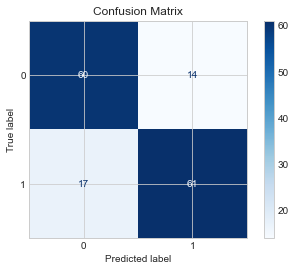



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.78      0.81      0.79        74
           1       0.81      0.78      0.80        78

    accuracy                           0.80       152
   macro avg       0.80      0.80      0.80       152
weighted avg       0.80      0.80      0.80       152



=== All AUC Scores ===
[0.90625    0.53125    0.91071429 0.66071429 0.78571429 0.875
 0.83928571 0.85714286 1.         0.85714286]


=== Mean AUC Score ===
Mean AUC Score :  0.8223214285714286


=== Total count ===
Total of active glovers : 74  Predicted number of active glovers : 77
Delta = 4.054%


In [52]:
# Results on the test set
XGB_optimal.fit(X_train, y_train)
XGB_optimal_predict = XGB.predict(X_test)
XGB_cv_score = cross_val_score(XGB_optimal, X_test, y_test, cv=10, scoring='roc_auc')
print_metrics(XGB_optimal,XGB_cv_score,X_test,y_test)

The ROC AUC is quit high (0.82) as well as the f1 score (0.80). The Delta value (difference between working glovers during the churn window and predicted non-churning glovers) is as expected positive (which favors the market place reliability) but yet small (4%) which guarantee at the same time a good cost efficiency. <br> <br>
Depending on the business priority we can still change the value of the threshold:

In [53]:
#function that returns the f1 score and the Delta depending on the inputed value of threshold:

def scores_threshold(threshold, X_test, y_test, model = XGB_optimal): 
    prediction = (model.predict_proba(X_test)[:,1] >= threshold).astype(int)
    f1 = f1_score(y_test, prediction)
    Delta = round((100*(sum(prediction==0) - sum(y_test==0))/sum(y_test==0) ),3)
    return f1,Delta

In [54]:
# test of several thresholds:
f1 = []
Delta = []
thresholds = np.array(range(400,520,1))*0.001
for threshold in (thresholds):
    f1.append(scores_threshold(threshold,X_test,y_test)[0])
    Delta.append(scores_threshold(threshold,X_test,y_test)[1])

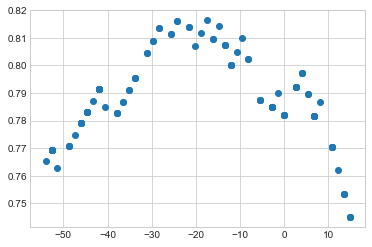

In [55]:
plt.scatter(Delta,f1)

Now that we have an efficient model, and as said before, if we want to prioritize the reliability we can keen this threshold value and if we want more cost efficiency and a better glovers' income maximization, we can still lower this threshold value. 

### 2. Model interpretation and features importances <a name="subparagraph3.2"></a>

In order to display the feature importance and to interpret our model a posteriori, I decided to retrain the XGBoost classifier with the initial features without the processing used to solve the correlation issues (PCA). <br>
As a matter of fact, if the management priority is the __interpretability of the model__, we shouldn't use a PCA but just get rid of feature_5 wich was -1 correlated to feature_4. That way and with an algorithm such as Random Forest or Gradient Tree Boosting, we can avoid the "black box issue". <br> 
On the other hand, if the main goal is the algorithm performance, PCA is a good solution. 

In [56]:
# PROCESSING OF THE DATASET WITHOUT THE PCA

df_lifetime = pd.read_csv(r"Courier_lifetime_data.csv", sep=",")
df_week = pd.read_csv(r"Courier_weekly_data.csv", sep=",")

#creation of the columns names:
col_name = ['courier']
for j in range(12):
    col_name.append('w_'+str(j))
    for i in range(17):
        col_name.append('w_'+str(j)+'_feature_'+str(i+1)) 

# creation of df_processed which will be used for the exploratory data analysis
df_feature_importance = pd.DataFrame([],columns = col_name) 
# copy of the glovers id:

df_feature_importance.courier = df_week.courier.unique()
len(df_week.courier.unique())
# fill of the 'worked on week i' features:
df_feature_importance[['w_' + str(i) for i in range(12)]] = df_worked_week.iloc[:,1:-1]

# fill the w_i_feature_j (with the value from df_week when it is avaible (when the glover worked) 
# or with the mean of the mean of the feature otherwise :

x=1
pbar = ProgressBar()
for i, courier in enumerate(pbar(df_feature_importance.courier)):
    for w in range(12):
        if df_week[(df_week.courier == courier) & (df_week.week == w)].empty : #if the glover courier didn't work on week w,
            #we replace the value by the average value of the feature. 
            df_feature_importance.iloc[i:i+1,w*18+2:w*18+19] = list(df_week.describe().loc['mean',:])[2:]
        else: #otherwise we just input the known value
            df_feature_importance.iloc[i:i+1,w*18+2:w*18+19] = list(df_week[(df_week['courier'] == courier) & (df_week['week'] == w)].iloc[0,2:])

# add of the target to the data frame:

df_feature_importance ['target'] = df_worked_week ['target']

# Left join on the lifetime Data Frame to get 
df_feature_importance = df_feature_importance.merge(df_lifetime, left_on='courier', right_on='courier', how='inner')
df_feature_importance = df_feature_importance.rename(columns = {'feature_1':'lt_feature_1','feature_2':'lt_feature_2'})

# make courier the key
df_feature_importance.set_index('courier', inplace = True)

df_feature_importance = pd.concat([df_feature_importance, pd.get_dummies(df_feature_importance['lt_feature_1'],prefix = 'lt_feature_1')], axis = 1)
df_feature_importance.drop('lt_feature_1', axis=1, inplace = True)

# remove of the weeks 8 to 11:
df_feature_importance = pd.concat([df_feature_importance.iloc[:,0:-78], df_feature_importance.iloc[:,-6:]],axis = 1)

df_feature_importance.head()



100% |########################################################################|


,w_0,w_0_feature_1,w_0_feature_2,w_0_feature_3,w_0_feature_4,w_0_feature_5,w_0_feature_6,w_0_feature_7,w_0_feature_8,w_0_feature_9,...,w_7_feature_14,w_7_feature_15,w_7_feature_16,w_7_feature_17,target,lt_feature_2,lt_feature_1_a,lt_feature_1_b,lt_feature_1_c,lt_feature_1_d
courier,,,,,,,,,,,,,,,,,,,,,
3767,0,-3.70245,44.2322,55.691,0.0686105,0.93139,104.332,0.0593392,3975.81,0.767527,...,0.782381,68.6556,2.25553,12.7894,1,33.0,0,1,0,0
6282,0,-3.70245,44.2322,55.691,0.0686105,0.93139,104.332,0.0593392,3975.81,0.767527,...,0.9107,65.6188,2,4,0,35.0,1,0,0,0
10622,1,5,82,45,0.1111,0.8889,100,0.0889,2476.29,0.5333,...,0.782381,68.6556,2.25553,12.7894,1,35.0,0,1,0,0
13096,0,-3.70245,44.2322,55.691,0.0686105,0.93139,104.332,0.0593392,3975.81,0.767527,...,0.782381,68.6556,2.25553,12.7894,0,35.0,1,0,0,0
14261,1,4,79,59,0.0339,0.9661,123.576,0.1695,3788.98,0.8136,...,0.9155,44.7132,1,8,1,44.0,1,0,0,0


Since we are using a Tree based method, there is no need to normalize our dataframe here.

In [57]:
# Train Test split
X_feature_importance = df_feature_importance.apply(pd.to_numeric).drop('target', axis=1)
y_feature_importance = df_feature_importance['target'].apply(pd.to_numeric)
X_train_feature_importance, X_test_feature_importance, y_train_feature_importance, y_test_feature_importance = train_test_split(X_feature_importance, y_feature_importance, test_size = 0.33, random_state = 66)

XGB_feature_importance = XGBClassifier()
XGB_feature_importance.fit(X_train_feature_importance, y_train_feature_importance)
XGB_predict_feature_importance = XGB_feature_importance.predict(X_test_feature_importance)
XGB_cv_score_feature_importance = cross_val_score(XGB_feature_importance, X, y, cv=10, scoring='roc_auc')


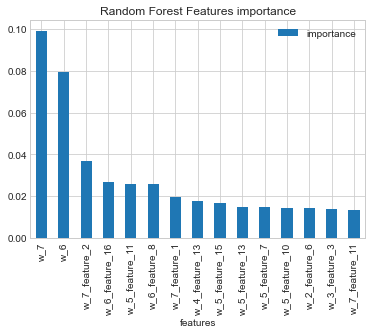

In [58]:
# Vizualisation of the most influent features in our model: 

forest_viz = pd.DataFrame()
forest_viz['features'] = X_feature_importance.columns
forest_viz['importance'] = XGB_feature_importance.feature_importances_
forest_viz = forest_viz.sort_values(by=['importance'],ascending=False)[:15]
forest_viz = forest_viz.set_index('features')
forest_viz.plot(kind='bar',title='Random Forest Features importance')

We can notice that the most important features by far are w_7 and w_6: the fact that a glover worked the week before the churn window. 


### Next steps : <br>
Some of the next steps which would be interesting to explore :

- We supposed that the glovers geographicall repartition is optimal. But it might not be the case. After a prediction for the next three weeks we could adapt the fleet, but it might not solve all the fleet issues. Indeed, some areas might suffer from a lake of glovers while others would have at the same time too many of them. It would then be relevant to analyse the geographical repartition and to segment our churn prediction by areas. 
- Another point of interest could be to analyse the potential existence of clusters among the glovers community and figure out if there is different churning behaviours.
- Regarding the model we used, none of them really took into account the temporality of our datas. A time series analalysis or a sequential model such as a LSTM could be interesting to try. Concerning the LSTM architecture, regarding the fact that part of the features are temporal (week data) and some are not (lifetime), we could use the following architectures:
    + A many-to-many LSTM with 7 cells and a fixed number of outputs concatanated with the lifetime features and then given as an input for a classic Multi Layer Perceptron with a sigmoid output. 
- Finnally, in order to create a pipeline later on, it would be a good point to gather the differents steps : Data Processing, Training, Prediction; into 3 methods of a global Class. That way we would just have to create an instance of the model, call the three methods and extract the predictions. We could then creat a batch and deploy the tool. 